# MediaPipe Pose Visualization for All Exercises

This notebook processes all video files in the `exercises/` folder and displays the MediaPipe stick figure overlays to verify pose detection quality.

In [7]:
import cv2
import mediapipe as mp
import numpy as np
import os
import glob
from IPython import display as ipydisplay
import time

mp_pose = mp.solutions.pose
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles

## Visualize MediaPipe Stick Figures for All Exercises

In [8]:
def visualize_all_exercises(folder='exercises', skip_frames=2, max_frames_per_video=100):
    """
    Process all videos in the exercises folder and display MediaPipe stick figures.
    
    Args:
        folder: path to exercises folder
        skip_frames: process every Nth frame (higher = faster but less smooth)
        max_frames_per_video: maximum frames to show per video (prevents very long displays)
    """
    if not os.path.exists(folder):
        print(f"Folder '{folder}' not found. Please create it and add exercise videos.")
        return
    
    # Find all video files
    video_files = []
    for ext in ['*.mp4', '*.avi', '*.mov', '*.MP4', '*.AVI', '*.MOV']:
        video_files.extend(glob.glob(os.path.join(folder, ext)))
    
    if not video_files:
        print(f"No video files found in '{folder}/'")
        return
    
    print(f"Found {len(video_files)} video(s): {[os.path.basename(f) for f in video_files]}")
    print()
    
    # Initialize MediaPipe Pose
    pose = mp_pose.Pose(
        static_image_mode=False,
        model_complexity=1,
        smooth_landmarks=True,
        min_detection_confidence=0.5,
        min_tracking_confidence=0.5
    )
    
    # Create display handle for updating the same output
    display_handle = ipydisplay.display(ipydisplay.Image(data=b''), display_id=True)
    
    try:
        for video_path in video_files:
            video_name = os.path.basename(video_path)
            print(f"\n{'='*60}")
            print(f"Processing: {video_name}")
            print(f"{'='*60}")
            
            cap = cv2.VideoCapture(video_path)
            if not cap.isOpened():
                print(f"  ❌ Failed to open {video_name}")
                continue
            
            fps = cap.get(cv2.CAP_PROP_FPS) or 30
            total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
            print(f"  📹 FPS: {fps:.1f} | Total frames: {total_frames}")
            
            frame_count = 0
            processed_count = 0
            detected_count = 0
            
            while cap.isOpened() and processed_count < max_frames_per_video:
                ret, frame = cap.read()
                if not ret:
                    break
                
                # Skip frames for performance
                if frame_count % (skip_frames + 1) != 0:
                    frame_count += 1
                    continue
                
                frame_count += 1
                processed_count += 1
                
                # Convert to RGB for MediaPipe
                rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                results = pose.process(rgb_frame)
                
                # Draw pose landmarks on the frame
                annotated_frame = frame.copy()
                
                if results.pose_landmarks:
                    detected_count += 1
                    
                    # Draw landmarks and connections
                    mp_drawing.draw_landmarks(
                        annotated_frame,
                        results.pose_landmarks,
                        mp_pose.POSE_CONNECTIONS,
                        landmark_drawing_spec=mp_drawing_styles.get_default_pose_landmarks_style()
                    )
                    
                    # Add status text
                    cv2.putText(
                        annotated_frame,
                        f"Frame {frame_count}/{total_frames} - POSE DETECTED",
                        (10, 30),
                        cv2.FONT_HERSHEY_SIMPLEX,
                        0.7,
                        (0, 255, 0),
                        2
                    )
                else:
                    # No pose detected
                    cv2.putText(
                        annotated_frame,
                        f"Frame {frame_count}/{total_frames} - NO POSE",
                        (10, 30),
                        cv2.FONT_HERSHEY_SIMPLEX,
                        0.7,
                        (0, 0, 255),
                        2
                    )
                
                # Add video name
                cv2.putText(
                    annotated_frame,
                    video_name,
                    (10, annotated_frame.shape[0] - 10),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    0.6,
                    (255, 255, 255),
                    2
                )
                
                # Encode and display
                _, buffer = cv2.imencode('.jpg', annotated_frame, [int(cv2.IMWRITE_JPEG_QUALITY), 85])
                display_handle.update(ipydisplay.Image(data=buffer.tobytes()))
                
                # Small delay for visualization (adjust as needed)
                time.sleep(0.05)
            
            cap.release()
            
            detection_rate = (detected_count / processed_count * 100) if processed_count > 0 else 0
            print(f"  ✅ Processed {processed_count} frames | Pose detected in {detected_count} ({detection_rate:.1f}%)")
    
    except KeyboardInterrupt:
        print("\n\n⚠️  Visualization interrupted by user")
    
    finally:
        pose.close()
        ipydisplay.clear_output(wait=True)
        print("\n" + "="*60)
        print("✅ Visualization complete!")
        print("="*60)

# Run visualization
visualize_all_exercises(folder='exercises', skip_frames=2, max_frames_per_video=150)


✅ Visualization complete!


## Visualize with Stick Figure Only (No Original Video)


✅ Complete!
Found 2 video(s)


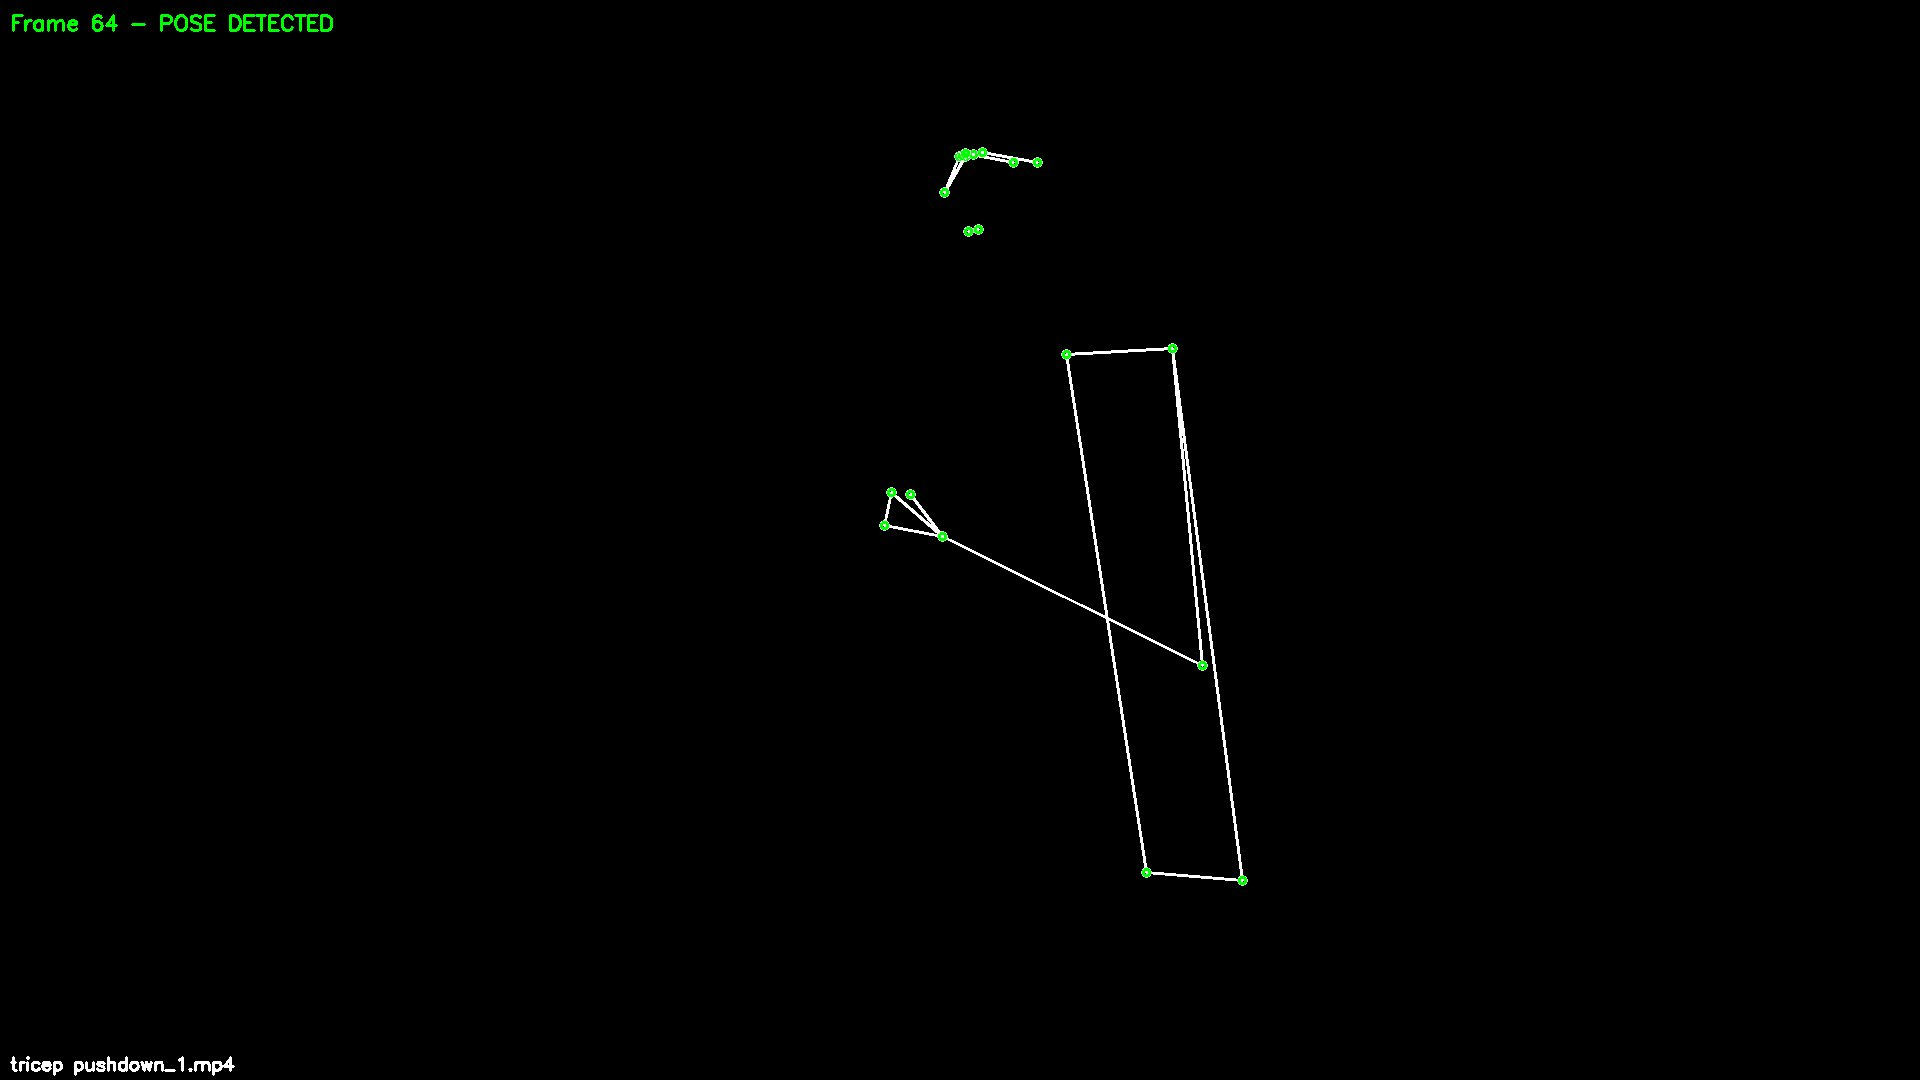


Processing: tricep pushdown_1.mp4 (stick figure only)


In [ ]:
def visualize_stick_figures_only(folder='exercises', skip_frames=2, max_frames_per_video=100):
    """
    Show only the stick figure skeleton on a black background (no original video).
    Useful for focusing on the pose structure.
    """
    if not os.path.exists(folder):
        print(f"Folder '{folder}' not found.")
        return
    
    video_files = []
    for ext in ['*.mp4', '*.avi', '*.mov', '*.MP4', '*.AVI', '*.MOV']:
        video_files.extend(glob.glob(os.path.join(folder, ext)))
    
    if not video_files:
        print(f"No videos found in '{folder}/'")
        return
    
    print(f"Found {len(video_files)} video(s)")
    
    pose = mp_pose.Pose(static_image_mode=False, model_complexity=1)
    display_handle = ipydisplay.display(ipydisplay.Image(data=b''), display_id=True)
    
    try:
        for video_path in video_files:
            video_name = os.path.basename(video_path)
            print(f"\n{'='*60}")
            print(f"Processing: {video_name} (stick figure only)")
            print(f"{'='*60}")
            
            cap = cv2.VideoCapture(video_path)
            if not cap.isOpened():
                continue
            
            frame_count = 0
            processed_count = 0
            
            # Get frame dimensions from first frame
            ret, first_frame = cap.read()
            if not ret:
                continue
            h, w = first_frame.shape[:2]
            cap.set(cv2.CAP_PROP_POS_FRAMES, 0)  # Reset to start
            
            while cap.isOpened() and processed_count < max_frames_per_video:
                ret, frame = cap.read()
                if not ret:
                    break
                
                if frame_count % (skip_frames + 1) != 0:
                    frame_count += 1
                    continue
                
                frame_count += 1
                processed_count += 1
                
                # Process with MediaPipe
                rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                results = pose.process(rgb_frame)
                
                # Create black canvas
                canvas = np.zeros((h, w, 3), dtype=np.uint8)
                
                if results.pose_landmarks:
                    # Draw stick figure on black background
                    mp_drawing.draw_landmarks(
                        canvas,
                        results.pose_landmarks,
                        mp_pose.POSE_CONNECTIONS,
                        landmark_drawing_spec=mp_drawing.DrawingSpec(color=(0, 255, 0), thickness=2, circle_radius=3),
                        connection_drawing_spec=mp_drawing.DrawingSpec(color=(255, 255, 255), thickness=2)
                    )
                    status_color = (0, 255, 0)
                    status_text = "POSE DETECTED"
                else:
                    status_color = (0, 0, 255)
                    status_text = "NO POSE"
                
                # Add info text
                cv2.putText(canvas, f"Frame {frame_count} - {status_text}", (10, 30),
                           cv2.FONT_HERSHEY_SIMPLEX, 0.7, status_color, 2)
                cv2.putText(canvas, video_name, (10, h - 10),
                           cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)
                
                _, buffer = cv2.imencode('.jpg', canvas, [int(cv2.IMWRITE_JPEG_QUALITY), 85])
                display_handle.update(ipydisplay.Image(data=buffer.tobytes()))
                time.sleep(0.05)
            
            cap.release()
            print(f"  ✅ Processed {processed_count} frames")
    
    except KeyboardInterrupt:
        print("\n⚠️  Interrupted")
    finally:
        pose.close()
        ipydisplay.clear_output(wait=True)
        print("\n✅ Complete!")

# Uncomment to run stick-figure-only visualization:
for i in range (1,10):
    visualize_stick_figures_only(folder='single', skip_frames=2, max_frames_per_video=150)
    

## Compare Side-by-Side: Original + Stick Figure

In [ ]:
def visualize_side_by_side(folder='exercises', skip_frames=2, max_frames_per_video=100):
    """
    Show original video frame and stick figure side by side.
    """
    if not os.path.exists(folder):
        print(f"Folder '{folder}' not found.")
        return
    
    video_files = []
    for ext in ['*.mp4', '*.avi', '*.mov', '*.MP4', '*.AVI', '*.MOV']:
        video_files.extend(glob.glob(os.path.join(folder, ext)))
    
    if not video_files:
        print(f"No videos found.")
        return
    
    pose = mp_pose.Pose(static_image_mode=False, model_complexity=1)
    display_handle = ipydisplay.display(ipydisplay.Image(data=b''), display_id=True)
    
    try:
        for video_path in video_files:
            video_name = os.path.basename(video_path)
            print(f"\n{'='*60}")
            print(f"Side-by-Side: {video_name}")
            print(f"{'='*60}")
            
            cap = cv2.VideoCapture(video_path)
            if not cap.isOpened():
                continue
            
            frame_count = 0
            processed_count = 0
            
            while cap.isOpened() and processed_count < max_frames_per_video:
                ret, frame = cap.read()
                if not ret:
                    break
                
                if frame_count % (skip_frames + 1) != 0:
                    frame_count += 1
                    continue
                
                frame_count += 1
                processed_count += 1
                
                h, w = frame.shape[:2]
                rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                results = pose.process(rgb_frame)
                
                # Left: original with overlay
                left = frame.copy()
                # Right: stick figure on black
                right = np.zeros((h, w, 3), dtype=np.uint8)
                
                if results.pose_landmarks:
                    mp_drawing.draw_landmarks(
                        left, results.pose_landmarks, mp_pose.POSE_CONNECTIONS,
                        landmark_drawing_spec=mp_drawing_styles.get_default_pose_landmarks_style()
                    )
                    mp_drawing.draw_landmarks(
                        right, results.pose_landmarks, mp_pose.POSE_CONNECTIONS,
                        landmark_drawing_spec=mp_drawing.DrawingSpec(color=(0, 255, 0), thickness=2, circle_radius=3),
                        connection_drawing_spec=mp_drawing.DrawingSpec(color=(255, 255, 255), thickness=2)
                    )
                
                # Combine side by side
                combined = np.hstack([left, right])
                
                # Add labels
                cv2.putText(combined, "Original + Overlay", (10, 30),
                           cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
                cv2.putText(combined, "Stick Figure Only", (w + 10, 30),
                           cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
                cv2.putText(combined, f"Frame {frame_count}", (10, h - 10),
                           cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)
                
                _, buffer = cv2.imencode('.jpg', combined, [int(cv2.IMWRITE_JPEG_QUALITY), 85])
                display_handle.update(ipydisplay.Image(data=buffer.tobytes()))
                time.sleep(0.05)
            
            cap.release()
            print(f"  ✅ Processed {processed_count} frames")
    
    except KeyboardInterrupt:
        print("\n⚠️  Interrupted")
    finally:
        pose.close()
        ipydisplay.clear_output(wait=True)
        print("\n✅ Complete!")

# Uncomment to run side-by-side visualization:
# visualize_side_by_side(folder='exercises', skip_frames=2, max_frames_per_video=150)